In [1]:
import numpy as np
import pickle

padded_features = np.load("../../data/processed_data/bezier_features_padded_high_precision.npy")
padded_target = np.load("../../data/processed_data/target_padded.npy")

with open("../../data/processed_data/alphabet", "rb") as f:
    alphabet = pickle.load(f)

print(padded_features.shape, padded_target.shape)

(11983, 192, 11) (11983, 64)


In [6]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [7]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda())

TensorFlow version: 2.9.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


In [8]:
def split_data(features, target, train_size=0.9):
    size = len(features)
    indices = np.arange(size)
    np.random.shuffle(indices)
    train_samples = int(size * train_size)
    
    x_train, y_train = features[indices[:train_samples]], target[indices[:train_samples]]
    x_valid, y_valid = features[indices[train_samples:]], target[indices[train_samples:]]
    
    return (
        x_train,
        x_valid,
        y_train,
        y_valid,
    )

x_train, x_valid, y_train, y_valid = split_data(padded_features, padded_target)

In [9]:
print(len(x_train), len(x_train[0]), len(x_train[0][0]))

10784 192 11


In [10]:
OUTPUT_SIZE = len(alphabet) + 1

N_BLSTM_LAYERS = 5
N_CELLS = 64

LEARNING_RATE = 10**-4

BATCH_SIZE = 8
N_FEATURES = len(x_train[0][0])
N_TIMESTEPS = len(x_train[0])
N_EPOCHS = 100

In [11]:
from keras.layers import Bidirectional, LSTM, Dense, Input, Masking, TimeDistributed

def build_model(n_blstm_layers, n_cells, n_features, output_size):
    model = tf.keras.models.Sequential()

    model.add(Masking(input_shape=(None, N_FEATURES), mask_value=np.zeros((N_FEATURES))))
    
    for i in range(n_blstm_layers):
        model.add(Bidirectional(LSTM(N_CELLS,
                                     input_shape=(None, N_FEATURES),
                                     return_sequences = True,
                                     dropout = 0.5),
                                merge_mode = 'sum'))

    model.add(
        TimeDistributed(
            Dense(output_size, activation = 'softmax')
        )
    )

    return model

In [12]:
def ctc_loss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [367]:
model = build_model(N_BLSTM_LAYERS, N_CELLS, N_FEATURES, OUTPUT_SIZE)

model.compile(
    loss=ctc_loss,
    optimizer= tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=9)
)

In [368]:
def create_dataset(train_data, valid_data, n_epochs, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((train_data, valid_data))
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(1)
    return dataset

train_dataset = create_dataset(x_train, y_train, N_EPOCHS, BATCH_SIZE)
validation_dataset = create_dataset(x_valid, y_valid, N_EPOCHS, BATCH_SIZE)

In [9]:
from pathlib import Path
import pickle
loss_history = [[], []]

if Path("../../training/encoder/loss").is_file():
    with open("../../training/encoder/loss", "rb") as f:
        loss_history = pickle.load(f)

EOFError: Ran out of input

In [370]:
# %%capture stored_output

import keras

checkpoint_path = "../../training/encoder_bezier/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

model.load_weights(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

logdir = '../../training/encoder_bezier/logs'
tb_callback = tf.keras.callbacks.TensorBoard(logdir, update_freq=1)

history = model.fit(
    train_dataset,
    validation_data = validation_dataset,
    shuffle=True,
    epochs = N_EPOCHS,
    batch_size = BATCH_SIZE,
    callbacks = [cp_callback, tb_callback]
)

Epoch 1/100
1348/1348 [==============================] - ETA: 0s - loss: 11.6642
Epoch 1: saving model to ../../training/encoder_bezier/cp.ckpt
1348/1348 [==============================] - 151s 83ms/step - loss: 11.6642 - val_loss: 10.9599
Epoch 2/100
1348/1348 [==============================] - ETA: 0s - loss: 11.6742
Epoch 2: saving model to ../../training/encoder_bezier/cp.ckpt
1348/1348 [==============================] - 100s 74ms/step - loss: 11.6742 - val_loss: 11.1398
Epoch 3/100
1348/1348 [==============================] - ETA: 0s - loss: 11.6316
Epoch 3: saving model to ../../training/encoder_bezier/cp.ckpt
1348/1348 [==============================] - 100s 74ms/step - loss: 11.6316 - val_loss: 10.8395
Epoch 4/100
1348/1348 [==============================] - ETA: 0s - loss: 11.6226
Epoch 4: saving model to ../../training/encoder_bezier/cp.ckpt
1348/1348 [==============================] - 101s 75ms/step - loss: 11.6226 - val_loss: 11.7941
Epoch 5/100
1348/1348 [=================

Epoch 35/100
1348/1348 [==============================] - ETA: 0s - loss: 11.4292
Epoch 35: saving model to ../../training/encoder_bezier/cp.ckpt
1348/1348 [==============================] - 101s 75ms/step - loss: 11.4292 - val_loss: 11.3737
Epoch 36/100
1348/1348 [==============================] - ETA: 0s - loss: 11.4058
Epoch 36: saving model to ../../training/encoder_bezier/cp.ckpt
1348/1348 [==============================] - 99s 74ms/step - loss: 11.4058 - val_loss: 11.1739
Epoch 37/100
1348/1348 [==============================] - ETA: 0s - loss: 11.4397
Epoch 37: saving model to ../../training/encoder_bezier/cp.ckpt
1348/1348 [==============================] - 100s 74ms/step - loss: 11.4397 - val_loss: 11.4879
Epoch 38/100
1348/1348 [==============================] - ETA: 0s - loss: 11.3981
Epoch 38: saving model to ../../training/encoder_bezier/cp.ckpt
1348/1348 [==============================] - 101s 75ms/step - loss: 11.3981 - val_loss: 11.5719
Epoch 39/100
1348/1348 [=========

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1348/1348 [==============================] - ETA: 0s - loss: 11.3273
Epoch 50: saving model to ../../training/encoder_bezier/cp.ckpt
1348/1348 [==============================] - 100s 74ms/step - loss: 11.3273 - val_loss: 10.9402
Epoch 51/100
1348/1348 [==============================] - ETA: 0s - loss: 11.3282
Epoch 51: saving model to ../../training/encoder_bezier/cp.ckpt
1348/1348 [==============================] - 99s 74ms/step - loss: 11.3282 - val_loss: 10.8328
Epoch 52/100
 869/1348 [==================>...........] - ETA: 34s - loss: 11.2765

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1348/1348 [==============================] - ETA: 0s - loss: 11.3286
Epoch 56: saving model to ../../training/encoder_bezier/cp.ckpt
1348/1348 [==============================] - 100s 74ms/step - loss: 11.3286 - val_loss: 11.0405
Epoch 57/100
1348/1348 [==============================] - ETA: 0s - loss: 11.2746
Epoch 57: saving model to ../../training/encoder_bezier/cp.ckpt
1348/1348 [==============================] - 99s 74ms/step - loss: 11.2746 - val_loss: 11.0440
Epoch 58/100
1148/1348 [========================>.....] - ETA: 14s - loss: 11.3005

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1348/1348 [==============================] - ETA: 0s - loss: 11.2377
Epoch 61: saving model to ../../training/encoder_bezier/cp.ckpt
1348/1348 [==============================] - 100s 74ms/step - loss: 11.2377 - val_loss: 10.6460
Epoch 62/100
 393/1348 [=======>......................] - ETA: 1:06 - loss: 11.2139

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1348/1348 [==============================] - ETA: 0s - loss: 11.2751
Epoch 63: saving model to ../../training/encoder_bezier/cp.ckpt
1348/1348 [==============================] - 100s 74ms/step - loss: 11.2751 - val_loss: 11.0867
Epoch 64/100
 978/1348 [====================>.........] - ETA: 26s - loss: 11.3283

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1348/1348 [==============================] - ETA: 0s - loss: 11.2427
Epoch 67: saving model to ../../training/encoder_bezier/cp.ckpt
1348/1348 [==============================] - 101s 75ms/step - loss: 11.2427 - val_loss: 11.1331
Epoch 68/100
 288/1348 [=====>........................] - ETA: 1:14 - loss: 11.3517

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1348/1348 [==============================] - ETA: 0s - loss: 11.2652
Epoch 69: saving model to ../../training/encoder_bezier/cp.ckpt
1348/1348 [==============================] - 100s 74ms/step - loss: 11.2652 - val_loss: 11.5231
Epoch 70/100
1098/1348 [=======================>......] - ETA: 17s - loss: 11.2673

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1348/1348 [==============================] - ETA: 0s - loss: 11.2121
Epoch 72: saving model to ../../training/encoder_bezier/cp.ckpt
1348/1348 [==============================] - 102s 76ms/step - loss: 11.2121 - val_loss: 11.4019
Epoch 73/100
1348/1348 [==============================] - ETA: 0s - loss: 11.2270
Epoch 73: saving model to ../../training/encoder_bezier/cp.ckpt
1348/1348 [==============================] - 101s 75ms/step - loss: 11.2270 - val_loss: 11.6003
Epoch 74/100
1348/1348 [==============================] - ETA: 0s - loss: 11.2309
Epoch 74: saving model to ../../training/encoder_bezier/cp.ckpt
1348/1348 [==============================] - 102s 76ms/step - loss: 11.2309 - val_loss: 11.0455
Epoch 75/100
1348/1348 [==============================] - ETA: 0s - loss: 11.2073
Epoch 75: saving model to ../../training/encoder_bezier/cp.ckpt
1348/1348 [==============================] - 100s 74ms/step - loss: 11.2073 - val_loss: 11.0097
Epoch 76/100
1348/1348 [=====================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1348/1348 [==============================] - ETA: 0s - loss: 11.1153
Epoch 90: saving model to ../../training/encoder_bezier/cp.ckpt
1348/1348 [==============================] - 102s 76ms/step - loss: 11.1153 - val_loss: 11.4832
Epoch 91/100
1348/1348 [==============================] - ETA: 0s - loss: 11.0629
Epoch 91: saving model to ../../training/encoder_bezier/cp.ckpt
1348/1348 [==============================] - 102s 76ms/step - loss: 11.0629 - val_loss: 11.7054
Epoch 92/100
1348/1348 [==============================] - ETA: 0s - loss: 11.1267
Epoch 92: saving model to ../../training/encoder_bezier/cp.ckpt
1348/1348 [==============================] - 101s 75ms/step - loss: 11.1267 - val_loss: 11.3581
Epoch 93/100
1348/1348 [==============================] - ETA: 0s - loss: 11.1181
Epoch 93: saving model to ../../training/encoder_bezier/cp.ckpt
1348/1348 [==============================] - 102s 76ms/step - loss: 11.1181 - val_loss: 11.5653
Epoch 94/100
1348/1348 [=====================

In [371]:
loss_history[0].extend(history.history['loss'])
loss_history[1].extend(history.history['val_loss'])

In [3]:
with open("../../training/encoder/loss", "wb") as f:
    pickle.dump(loss_history, f)

NameError: name 'pickle' is not defined

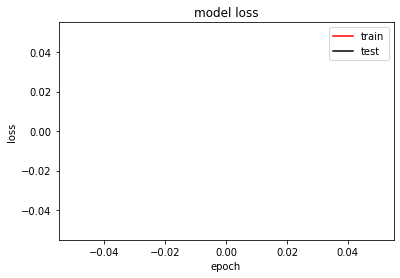

In [8]:
import matplotlib.pyplot as plt

def flatten_list(l):
     return [point for elem in l for point in elem]

plt.plot(loss_history[0], color="red", label="train")
plt.plot(loss_history[1], color="black", label="test")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [13]:
def plot_bezier_curves(data):
    current_x = 0
    current_y = 0
    
    for i, (dx, dy, d1, d2, a1, a2, g1, g2, g3, p1, p2) in enumerate(data):
        if p2:
            current_x += dx
            current_y += dy
            continue
        
        p0 = np.array([current_x, current_y])
        p3 = np.array([current_x + dx, current_y + dy])
                
        p1 = make_rotation_matrix(a1) @ np.array([dx, dy]) * d1 + np.array([current_x, current_y])
        p2 = make_rotation_matrix(a2) @ np.array([-dx, -dy]) * d2 + np.array([current_x + dx, current_y + dy])
        
#         plt.scatter(p0[0], p0[1])
#         plt.scatter(p1[0], p1[1])
#         plt.scatter(p2[0], p2[1])
#         plt.scatter(p3[0], p3[1])
#         plt.plot([p3[0], p2[0]], [p3[1], p2[1]])
#         plt.plot([p0[0], p1[0]], [p0[1], p1[1]])
        
        ts = np.linspace(0, 1, 100)
        xs = []
        ys = []
    
        for t in ts:
            (x, y) = bezier_curve(p0, p1, p2, p3, t)
            xs.append(x)
            ys.append(y)
            
        current_x = p3[0]
        current_y = p3[1]
        
        plt.plot(xs, ys, label=f"Bezier {i}")
    
    plt.xlabel("x")
    plt.ylabel("y")
    
def make_rotation_matrix(angle):
    return np.array([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])

def bezier_curve(p0, p1, p2, p3, t):
    return ((1-t)**3 * p0) + (3*(1-t)**2*t * p1) + (3*(1-t)*t**2 * p2) + (t**3 * p3)

plot_bezier_curves(padded_features[10])

# Add pciture of input
# Picture of fitted curves
# 120 epochs -. precision up

NameError: name 'plt' is not defined

In [14]:
print(len(loss_history[0]))

NameError: name 'loss_history' is not defined

In [17]:
from pathlib import Path
if Path("./../../data/processed_data/alphabet").is_file():
    with open("./../../data/processed_data/alphabet", "rb") as f:
        alphabet = pickle.load(f)

print(alphabet, len(alphabet))

def encode_textline(textline, alphabet):
    return [alphabet.index(c) for c in textline]

def decode_textline(encodedline, alphabet):
    return [alphabet[int(v)] if int(v) < len(alphabet) else "blank"for v in encodedline]

def remove_blanks(l):
    return [elem for elem in l if elem != "blank"]

['&', 'T', '!', 'h', '9', 'V', '\n', 'b', 'o', 'j', 'f', '"', 'i', 'Z', 'a', 'D', '?', '*', ':', '7', 'k', 's', 'B', 'R', '3', 'U', '8', 'n', 'l', ';', 'M', ',', ')', 'r', '#', 'G', 'm', 'A', 'x', 'O', '4', 'E', 'L', 'g', '6', 'F', '@', 'Q', 'q', 'u', '1', 'W', 'w', 'z', "'", 't', 'X', 'H', 'c', '[', 'p', 'C', '+', '5', 'd', 'P', '.', 'v', 'I', 'S', 'e', 'N', 'y', 'K', '/', '(', 'J', '0', '2', ' ', '-', 'Y'] 82


In [19]:
model = build_model(N_BLSTM_LAYERS, N_CELLS, N_FEATURES, OUTPUT_SIZE)
checkpoint_path = "../../training/encoder_bezier/cp.ckpt"
model.load_weights(checkpoint_path)

In [20]:
sample = 50
res = model.call(tf.convert_to_tensor(np.expand_dims(padded_features[sample], 0)), mask=None).numpy()[0]

In [21]:
argmax = np.argmax(res, axis=1)

his son. Now the judge was not
hiis  son.  Nvow  the  juouge  was  not


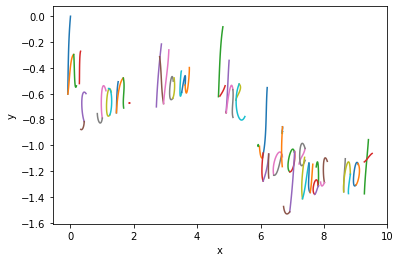

In [23]:
import matplotlib.pyplot as plt

print("".join(remove_blanks(decode_textline(padded_target[sample], alphabet))))

print("".join(remove_blanks(decode_textline(argmax, alphabet))))

plot_bezier_curves(padded_features[sample])

In [24]:
np.save("test", padded_features[sample])